# Prototype - iota

| Properties           | Data                 |
| -------------------- | -------------------- |
| *Labels*             | `['BENIGN', 'DDoS']` |
| *Normalization*      | `Min-Max`            |
| *Sample Size*        | `40.000`               |
| *Adversarial Attack* | `FGSM & C&W & PGD & JSMA`               |
| *Explanations*       | `SHAP`               |
| *Detector*           | `Detect misclassified Samples of all White-Box Attacks`|

---

## *Has to be run first alone!*

In [1]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [10]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 20000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=42)
print(f"Generate Features | Indices: {feature_df.index[:5]}... | Shape: {feature_df.shape}")
print(f"Generate Labels | Indices: {label_df.index[:5]}... | Shape: {label_df.shape}")
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (40000, 79)
--- Splitti

## Split Data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32000, 70) (8000, 70) (32000, 2) (8000, 2)


## Create IDS

In [40]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# TODO: build ids with complete dataset
# X_train_all, y_train_all, _ = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, random_sample_state=42)
# print(y_train_all.value_counts())
# X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)
# print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

# build ids and evaluate it on test data
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)
# store prediction from X_train
y_pred = ids.predict(ids_model, X_train, columns=y_train.columns)
print(f"Predictions on Normal Data | Indices: {y_pred.index[:5]}... | Shape: {y_pred.shape}")

Epoch 1/10


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9127 - loss: 0.3673 - val_accuracy: 0.9806 - val_loss: 0.0486
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.9833 - loss: 0.0428 - val_accuracy: 0.9822 - val_loss: 0.0357
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9869 - loss: 0.0317 - val_accuracy: 0.9834 - val_loss: 0.0303
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.9875 - loss: 0.0266 - val_accuracy: 0.9837 - val_loss: 0.0275
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.9896 - loss: 0.0240 - val_accuracy: 0.9850 - val_loss: 0.0254
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.9897 - loss: 0.0221 - val_accuracy: 0.9873 - val_loss: 0.0234
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9903 - loss: 0.0206 - val_accuracy: 0.9889 - val_loss: 0.0221
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.9908 - loss: 0.0199 - val_accuracy:

## Generate Adversarial Attacks

In [8]:
from sklearn.utils import shuffle

def split_into_classes(X, y, class_labels):
    """
    Splits the dataset evenly into specified classes with given labels.

    Args:
        X (numpy.ndarray): The input samples.
        y (numpy.ndarray): The labels.
        class_labels (list of str): The names of the classes (e.g., ["normal", "cw", "fgsm", "hsj"]).

    Returns:
        dict: A dictionary where keys are class names and values are tuples (X_subset, y_subset).
    """
    num_classes = len(class_labels)

    if len(X) % num_classes != 0:
        raise ValueError("Number of samples must be evenly divisible by the number of classes.")

    # Shuffle data to avoid biases
    X, y = shuffle(X, y, random_state=42)

    # Compute samples per class
    num_samples_per_class = len(X) // num_classes

    # Dictionary to store the split datasets
    class_splits = {}

    for i, label in enumerate(class_labels):
        start = i * num_samples_per_class
        end = (i + 1) * num_samples_per_class
        class_splits[label] = (X[start:end], y[start:end])

    return class_splits


In [41]:
import functions.attack_generator as ag
import importlib
import numpy as np
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# Split the training data into classes
class_labels = ["normal", "cw", "fgsm", "jsma", "pgd"]  # Change this to any class names
splits = split_into_classes(X_train, y_train, class_labels)
X_normal, y_normal = splits["normal"]
X_cw, y_cw = splits["cw"]
X_fgsm, y_fgsm = splits["fgsm"]
X_jsma, y_jsma = splits["jsma"]
X_pgd, y_pgd = splits["pgd"]
print(f"Normal Data: {X_normal.shape} | CW Data: {X_cw.shape} | FGSM Data: {X_fgsm.shape} | JSMA Data: {X_jsma.shape} | PGD Data: {X_pgd.shape}")

# generate attacks on the separated training data
# TODO: when changing epsilon, the detector accuracy rises
X_adv_fgsm = ag.generate_fgsm_attacks(art_model, X_fgsm, target_label=1)
print(f"Create FGSM Adversarial Attack | Indices: {X_adv_fgsm.index[:5]}... | Shape: {X_adv_fgsm.shape}")
y_pred_adv_fgsm = ag.evaluate_art_model(art_model, X_adv_fgsm, y_fgsm)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_fgsm.index[:5]}... | Shape: {y_pred_adv_fgsm.shape}")
y_pred_fgsm = y_pred.loc[X_fgsm.index]

import multiprocessing
num_cores = multiprocessing.cpu_count()
X_adv_cw = ag.generate_cw_attacks_parallel(art_model, X_cw, target_label=1, num_cores=num_cores)
print(f"Create CW Adversarial Attack | Indices: {X_adv_cw.index[:5]}... | Shape: {X_adv_cw.shape}")
y_pred_adv_cw = ag.evaluate_art_model(art_model, X_adv_cw, y_cw)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_cw.index[:5]}... | Shape: {y_pred_adv_cw.shape}")
y_pred_cw = y_pred.loc[X_cw.index]

X_adv_jsma = ag.generate_jsma_attacks(art_model, X_jsma, target_label=1)
print(f"Create JSMA Adversarial Attack | Indices: {X_adv_jsma.index[:5]}... | Shape: {X_adv_jsma.shape}")
y_pred_adv_jsma = ag.evaluate_art_model(art_model, X_adv_jsma, y_jsma)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_jsma.index[:5]}... | Shape: {y_pred_adv_jsma.shape}")
y_pred_jsma = y_pred.loc[X_jsma.index]

X_adv_pgd = ag.generate_pgd_attacks(art_model, X_pgd, target_label=1)
print(f"Create HSJ Adversarial Attack | Indices: {X_adv_pgd.index[:5]}... | Shape: {X_adv_pgd.shape}")
y_pred_adv_pgd = ag.evaluate_art_model(art_model, X_adv_pgd, y_pgd)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_pgd.index[:5]}... | Shape: {y_pred_adv_pgd.shape}")
y_pred_pgd = y_pred.loc[X_pgd.index]

Normal Data: (6400, 70) | CW Data: (6400, 70) | FGSM Data: (6400, 70) | JSMA Data: (6400, 70) | PGD Data: (6400, 70)
Adversarial FGSM examples generated. Shape: (6400, 70)
Create FGSM Adversarial Attack | Indices: Index([414312, 281272, 443688, 450214, 428606], dtype='int64')... | Shape: (6400, 70)
Accuracy: 49.36%
              precision    recall  f1-score   support

      ATTACK     0.0000    0.0000    0.0000      3241
      BENIGN     0.4936    1.0000    0.6609      3159

    accuracy                         0.4936      6400
   macro avg     0.2468    0.5000    0.3305      6400
weighted avg     0.2436    0.4936    0.3262      6400

Confusion Matrix: Positive == BENIGN
TN: 0, FP: 3241, FN: 0, TP: 3159
Predictions on Adversarial Attacks | Indices: Index([414312, 281272, 443688, 450214, 428606], dtype='int64')... | Shape: (6400, 2)
Running attack using 24 CPU cores...

Process 44690 is generating adversarial examples for batch of size 266 
Process 44691 is generating adversarial examp

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/282 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/266 [00:00<?, ?it/s]

Create CW Adversarial Attack | Indices: Index([367524, 403889, 1806823, 706236, 475346], dtype='int64')... | Shape: (6400, 70)
Accuracy: 76.42%
              precision    recall  f1-score   support

      ATTACK     1.0000    0.5237    0.6874      3168
      BENIGN     0.6817    1.0000    0.8107      3232

    accuracy                         0.7642      6400
   macro avg     0.8409    0.7618    0.7491      6400
weighted avg     0.8393    0.7642    0.7497      6400

Confusion Matrix: Positive == BENIGN
TN: 1659, FP: 1509, FN: 0, TP: 3232
Predictions on Adversarial Attacks | Indices: Index([367524, 403889, 1806823, 706236, 475346], dtype='int64')... | Shape: (6400, 2)


JSMA:   0%|          | 0/6400 [00:00<?, ?it/s]

Adversarial JSMA examples generated. Shape: (6400, 70)
Create JSMA Adversarial Attack | Indices: Index([79319, 1836822, 1340447, 477738, 1361834], dtype='int64')... | Shape: (6400, 70)
Accuracy: 50.98%
              precision    recall  f1-score   support

      ATTACK     0.0000    0.0000    0.0000      3137
      BENIGN     0.5098    1.0000    0.6754      3263

    accuracy                         0.5098      6400
   macro avg     0.2549    0.5000    0.3377      6400
weighted avg     0.2599    0.5098    0.3443      6400

Confusion Matrix: Positive == BENIGN
TN: 0, FP: 3137, FN: 0, TP: 3263
Predictions on Adversarial Attacks | Indices: Index([79319, 1836822, 1340447, 477738, 1361834], dtype='int64')... | Shape: (6400, 2)


PGD - Batches: 0it [00:00, ?it/s]

2025-03-28 11:00:55.979153: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Adversarial PGD examples generated. Shape: (6400, 70)
Create HSJ Adversarial Attack | Indices: Index([359920, 2032524, 2720032, 410469, 440128], dtype='int64')... | Shape: (6400, 70)
Accuracy: 50.00%
              precision    recall  f1-score   support

      ATTACK     0.0000    0.0000    0.0000      3200
      BENIGN     0.5000    1.0000    0.6667      3200

    accuracy                         0.5000      6400
   macro avg     0.2500    0.5000    0.3333      6400
weighted avg     0.2500    0.5000    0.3333      6400

Confusion Matrix: Positive == BENIGN
TN: 0, FP: 3200, FN: 0, TP: 3200
Predictions on Adversarial Attacks | Indices: Index([359920, 2032524, 2720032, 410469, 440128], dtype='int64')... | Shape: (6400, 2)


In [14]:
def get_correctly_benign_classified_indices(y_train, y_pred):
    benign_indices = y_train[y_train['BENIGN'] == 1].index
    benign_adv_predicted_indices = y_pred[y_pred['BENIGN'] == 1].index
    correctly_benign_classified_indices = benign_indices.intersection(benign_adv_predicted_indices)
    return correctly_benign_classified_indices

def get_misclassified_as_benign_due_attack_indices(y_train, y_pred, y_pred_adv):
    attack_indices = y_train[y_train['ATTACK'] == 1].index
    attack_adv_predicted_indices = y_pred[y_pred['ATTACK'] == 1].index
    benign_predicted_adversarial_indices = y_pred_adv[y_pred_adv['BENIGN'] == 1].index
    misclassified_as_benign_due_attack_indices = attack_indices.intersection(attack_adv_predicted_indices).intersection(benign_predicted_adversarial_indices)
    return misclassified_as_benign_due_attack_indices

In [15]:
y_pred_normal = y_pred.loc[X_normal.index]
correctly_benign_classified_indices = get_correctly_benign_classified_indices(y_normal, y_pred_normal)

correctly_benign_classified_indices_fgsm = get_correctly_benign_classified_indices(y_fgsm, y_pred_adv_fgsm)
misclassified_as_benign_due_attack_indices_fgsm = get_misclassified_as_benign_due_attack_indices(y_fgsm, y_pred_fgsm, y_pred_adv_fgsm)

correctly_benign_classified_indices_cw = get_correctly_benign_classified_indices(y_cw, y_pred_cw)
misclassified_as_benign_due_attack_indices_cw = get_misclassified_as_benign_due_attack_indices(y_cw, y_pred_cw, y_pred_adv_cw)

correctly_benign_classified_indices_jsma = get_correctly_benign_classified_indices(y_jsma, y_pred_jsma)
misclassified_as_benign_due_attack_indices_jsma = get_misclassified_as_benign_due_attack_indices(y_jsma, y_pred_jsma, y_pred_adv_jsma)

# TODO: is it correct to only include the samples that are correctly classified from the IDS?
correctly_benign_classified_indices_pgd = get_correctly_benign_classified_indices(y_pgd, y_pred_pgd)
misclassified_as_benign_due_attack_indices_pgd = get_misclassified_as_benign_due_attack_indices(y_pgd, y_pred_pgd, y_pred_adv_pgd)

print(f"Correctly classified as BENIGN from the IDS: {len(correctly_benign_classified_indices)} | Indices: {correctly_benign_classified_indices[:3]}")
print(f"    Correctly classified as BENIGN from the IDS (FGSM): {len(correctly_benign_classified_indices_fgsm)} | Indices: {correctly_benign_classified_indices_fgsm[:3]}")
print(f"    ATTACK sample misclassified as BENIGN due to adversarial attack (FGSM): {len(misclassified_as_benign_due_attack_indices_fgsm)} | Indices: {misclassified_as_benign_due_attack_indices_fgsm[:3]}")
print(f"        Correctly classified as BENIGN from the IDS (CW): {len(correctly_benign_classified_indices_cw)} | Indices: {correctly_benign_classified_indices_cw[:3]}")
print(f"        ATTACK sample misclassified as BENIGN due to adversarial attack (CW): {len(misclassified_as_benign_due_attack_indices_cw)} | Indices: {misclassified_as_benign_due_attack_indices_cw[:3]}")
print(f"            Correctly classified as BENIGN from the IDS (PGD): {len(correctly_benign_classified_indices_pgd)} | Indices: {correctly_benign_classified_indices_pgd[:3]}")
print(f"            ATTACK sample misclassified as BENIGN due to adversarial attack (PGD): {len(misclassified_as_benign_due_attack_indices_pgd)} | Indices: {misclassified_as_benign_due_attack_indices_pgd[:3]}")
print(f"                Correctly classified as BENIGN from the IDS (JSMA): {len(correctly_benign_classified_indices_jsma)} | Indices: {correctly_benign_classified_indices_jsma[:3]}")
print(f"                ATTACK sample misclassified as BENIGN due to adversarial attack (JSMA): {len(misclassified_as_benign_due_attack_indices_jsma)} | Indices: {misclassified_as_benign_due_attack_indices_jsma[:3]}")

Correctly classified as BENIGN from the IDS: 3085 | Indices: Index([606504, 2655053, 820505], dtype='int64')
    Correctly classified as BENIGN from the IDS (FGSM): 3159 | Indices: Index([281272, 443688, 2048428], dtype='int64')
    ATTACK sample misclassified as BENIGN due to adversarial attack (FGSM): 3237 | Indices: Index([414312, 450214, 428606], dtype='int64')
        Correctly classified as BENIGN from the IDS (CW): 3185 | Indices: Index([1806823, 706236, 1671681], dtype='int64')
        ATTACK sample misclassified as BENIGN due to adversarial attack (CW): 1509 | Indices: Index([367524, 403889, 475346], dtype='int64')
            Correctly classified as BENIGN from the IDS (PGD): 3158 | Indices: Index([2032524, 2720032, 979762], dtype='int64')
            ATTACK sample misclassified as BENIGN due to adversarial attack (PGD): 3193 | Indices: Index([359920, 410469, 440128], dtype='int64')
                Correctly classified as BENIGN from the IDS (JSMA): 3214 | Indices: Index([793

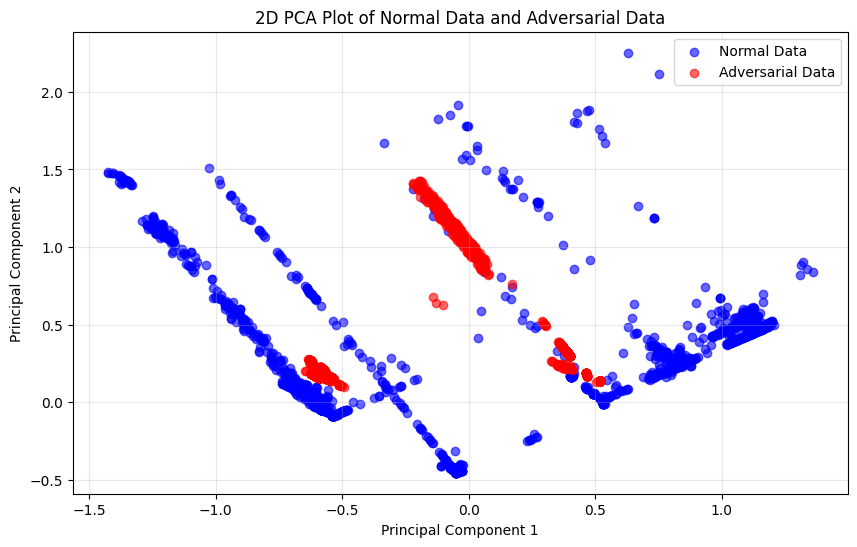

In [ ]:
# import functions.visualizer as visualizer
# import importlib
# importlib.reload(visualizer)

# visualizer.visualize_data_distribution(X_train.loc[correctly_benign_classified_indices], 'Normal Data', X_adv_fgsm.loc[misclassified_as_benign_due_attack_indices_fgsm], 'Adversarial Data')
# # visualizer.pca_visualization_side_by_side(X_train.loc[misclassified_as_benign_due_attack_indices], 'Normal Data', X_adv.loc[misclassified_as_benign_due_attack_indices], 'Adversarial Data')

## Explainer

In [ ]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values_df = exp.generate_shap_values(explainer, X_normal)
print(f"Generate Explanations | Indices: {shap_values_df.index[:5]}... | Shape: {shap_values_df.shape}")

shap_values_adv_df_fgsm = exp.generate_shap_values(explainer, X_adv_fgsm)
print(f"Generate FGSM Adversarial Explanations | Indices: {shap_values_adv_df_fgsm.index[:5]}... | Shape: {shap_values_adv_df_fgsm.shape}")

shap_values_adv_df_cw = exp.generate_shap_values(explainer, X_adv_cw)
print(f"Generate CW Adversarial Explanations | Indices: {shap_values_adv_df_cw.index[:5]}... | Shape: {shap_values_adv_df_cw.shape}")

shap_values_adv_df_jsma = exp.generate_shap_values(explainer, X_adv_jsma)
print(f"Generate JSMA Adversarial Explanations | Indices: {shap_values_adv_df_jsma.index[:5]}... | Shape: {shap_values_adv_df_jsma.shape}")

shap_values_adv_df_pgd = exp.generate_shap_values(explainer, X_adv_pgd)
print(f"Generate PGD Adversarial Explanations | Indices: {shap_values_adv_df_pgd.index[:5]}... | Shape: {shap_values_adv_df_pgd.shape}")

PermutationExplainer explainer: 6401it [03:20, 30.87it/s]                          


Generate Explanations | Indices: Index([361750, 450213, 394721, 334148, 380045], dtype='int64')... | Shape: (6400, 70)


PermutationExplainer explainer: 6401it [03:09, 32.08it/s]                          


Generate FGSM Adversarial Explanations | Indices: Index([414312, 281272, 443688, 450214, 428606], dtype='int64')... | Shape: (6400, 70)


PermutationExplainer explainer: 6401it [03:22, 30.20it/s]                          


Generate CW Adversarial Explanations | Indices: Index([367524, 403889, 1806823, 706236, 475346], dtype='int64')... | Shape: (6400, 70)


PermutationExplainer explainer: 6401it [03:18, 30.66it/s]                          


Generate JSMA Adversarial Explanations | Indices: Index([79319, 1836822, 1340447, 477738, 1361834], dtype='int64')... | Shape: (6400, 70)


PermutationExplainer explainer: 6401it [03:06, 32.48it/s]                          


Generate PGD Adversarial Explanations | Indices: Index([359920, 2032524, 2720032, 410469, 440128], dtype='int64')... | Shape: (6400, 70)


In [19]:
import pandas as pd
concat_correctly_benign_classified_shaps = pd.concat([
    shap_values_df.loc[correctly_benign_classified_indices], 
    shap_values_adv_df_fgsm.loc[correctly_benign_classified_indices_fgsm], 
    shap_values_adv_df_cw.loc[correctly_benign_classified_indices_cw], 
    shap_values_adv_df_jsma.loc[correctly_benign_classified_indices_jsma],
    shap_values_adv_df_pgd.loc[correctly_benign_classified_indices_pgd]
    ], axis=0)
# shap_values_df.loc[misclassified_as_benign_due_attack_indices]
concat_misclassified_as_benign_shaps = pd.concat([
    shap_values_adv_df_fgsm.loc[misclassified_as_benign_due_attack_indices_fgsm], 
    shap_values_adv_df_cw.loc[misclassified_as_benign_due_attack_indices_cw], 
    shap_values_adv_df_jsma.loc[misclassified_as_benign_due_attack_indices_jsma],
    shap_values_adv_df_pgd.loc[misclassified_as_benign_due_attack_indices_pgd]
    ], axis=0)

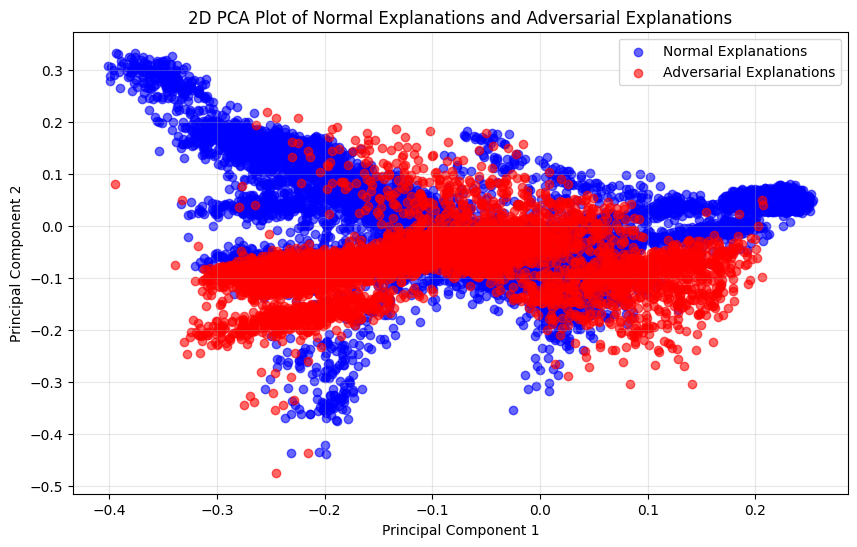

In [20]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(concat_correctly_benign_classified_shaps, 'Normal Explanations', concat_misclassified_as_benign_shaps, 'Adversarial Explanations')

In [ ]:
# exp.plot_shap_summary_comparison(shap_values_df.loc[correctly_benign_classified_indices].values, X_train.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices].values, X_adv.loc[misclassified_as_benign_due_attack_indices], 6, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [21]:
import functions.detector as det
import importlib
importlib.reload(det)

# build detector to detect adversarial samples that misclassify attack samples as benign

# create dataframe
# TODO: build detector with normal and adversarial shap values?
# TODO: build with shap_values_adv_df to detect 'BENIGN' and 'ATTACK'
import pandas as pd

# alternative approach: detector that predicts the original label of the sample for all given adversarial attacks
# concat_correctly_benign_classified_shaps = pd.concat([shap_values_df.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[correctly_benign_classified_indices]], axis=0)
# concat_misclassified_as_benign_shaps = pd.concat([shap_values_df.loc[misclassified_as_benign_due_attack_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices]], axis=0)
X, y = det.build_train_datasets(concat_correctly_benign_classified_shaps, concat_misclassified_as_benign_shaps)

#X, y = det.build_train_datasets(shap_values_df.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices])
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

(26872, 70) (26872, 2)
(24184, 70) (2688, 70) (24184, 2) (2688, 2)
Epoch 1/10


2025-03-28 09:56:58.737264: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7158 - loss: 0.5928 - val_accuracy: 0.9086 - val_loss: 0.2314
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9044 - loss: 0.2359 - val_accuracy: 0.9262 - val_loss: 0.1842
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9266 - loss: 0.1896 - val_accuracy: 0.9332 - val_loss: 0.1641
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.1678 - val_accuracy: 0.9392 - val_loss: 0.1465
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9428 - loss: 0.1530 - val_accuracy: 0.9434 - val_loss: 0.1381
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9479 - loss: 0.1391 - val_accuracy: 0.9471 - val_loss: 0.1289
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9515 - loss: 0.1345 - val_accuracy: 0.9469 - val_loss: 0.1300
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9544 - loss: 0.1225 - val_accuracy: 0.9570 - val_

---
## Manual Evaluation
We perform the whole two-stages approach on new unseen data and evaluate the following scores:
- Recall
- Precision
- Accuracy
- F1 Score

In [34]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_eval_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, used_eval_indices = dp.preprocess_data(dataset_eval_excluded, encoding_type, normalizer, zero_columns, sample_size=500, random_sample_state=15)
print(f"Generate Features | Indices: {X_eval.index[:5]}... | Shape: {X_eval.shape}")
print(f"Generate Labels | Indices: {y_eval.index[:5]}... | Shape: {y_eval.shape}")
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (1000, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
Generate Features | Indices: Index([77425, 2564390, 1015498, 2453382, 2156724], dtype='int64')... | Shape: (1000, 70)
Generate Labels | Indices: Index([77425, 2564390, 1015498, 2453382, 2156724], dtype='int64')... | Shape: (1000, 2)
BENIGN  ATTACK
False   True      500
True    False     500
Name: count, dtype: int64


In [59]:
importlib.reload(ag)

# X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=1, num_cores=num_cores)
# print(f"Create Adversarial Attack | Indices: {X_adv_eval.index[:5]}... | Shape: {X_adv_eval.shape}")

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, target_label=1, num_cores=24)
print(f"Create Adversarial Attack | Indices: {X_adv_eval.index[:5]}... | Shape: {X_adv_eval.shape}")

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

Running attack using 24 CPU cores...

Process 76336 is generating adversarial examples for batch of size 41 
Process 76335 is generating adversarial examples for batch of size 41 
Process 76337 is generating adversarial examples for batch of size 41 
Process 76339 is generating adversarial examples for batch of size 41 
Process 76340 is generating adversarial examples for batch of size 41 
Process 76342 is generating adversarial examples for batch of size 41 
Process 76338 is generating adversarial examples for batch of size 41 
Process 76344 is generating adversarial examples for batch of size 41 
Process 76343 is generating adversarial examples for batch of size 41 
Process 76341 is generating adversarial examples for batch of size 41 
Process 76346 is generating adversarial examples for batch of size 41 
Process 76347 is generating adversarial examples for batch of size 41 
Process 76345 is generating adversarial examples for batch of size 41 
Process 76348 is generating adversarial

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/57 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/41 [00:00<?, ?it/s]

Create Adversarial Attack | Indices: Index([77425, 2564390, 1015498, 2453382, 2156724], dtype='int64')... | Shape: (1000, 70)
Accuracy: 77.20%
              precision    recall  f1-score   support

      ATTACK     1.0000    0.5440    0.7047       500
      BENIGN     0.6868    1.0000    0.8143       500

    accuracy                         0.7720      1000
   macro avg     0.8434    0.7720    0.7595      1000
weighted avg     0.8434    0.7720    0.7595      1000

Confusion Matrix: Positive == BENIGN
TN: 272, FP: 228, FN: 0, TP: 500
Predictions on Adversarial Attacks | Indices: Index([77425, 2564390, 1015498, 2453382, 2156724], dtype='int64')... | Shape: (1000, 2)


In [ ]:
importlib.reload(exp)
X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)

print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

PermutationExplainer explainer: 1001it [00:32, 21.45it/s]                         

Create Explanations | Indices: Index([77425, 2564390, 1015498, 2453382, 2156724], dtype='int64')... | Shape: (1000, 70)


In [62]:
benign_eval_idx = y_eval[y_eval['BENIGN'] == 1].index
attack_eval_idx = y_eval[y_eval['ATTACK'] == 1].index

pred_benign_idx = y_pred_adv_eval[y_pred_adv_eval['BENIGN'] == 1].index
pred_attack_idx = y_pred_adv_eval[y_pred_adv_eval['ATTACK'] == 1].index

# predict
X_eval_detector = X_eval_adv_shap_values_df.loc[pred_benign_idx]

y_pred_eval_detector = det.predict(detector, X_eval_detector, y_eval.columns)
correctly_classified_det_idx = y_pred_eval_detector[y_pred_eval_detector['BENIGN'] == 1].index
misclassified_det_idx = y_pred_eval_detector[y_pred_eval_detector['ATTACK'] == 1].index


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


2025-03-28 11:14:50.660131: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [63]:
# After IDS Stage
TN = len(attack_eval_idx.intersection(pred_attack_idx)) # IDS classifies 'ATTACK' samples as 'ATTACK'
print(f"IDS classifies 'ATTACK' samples as 'ATTACK': {TN}")
FN = len(benign_eval_idx.intersection(pred_attack_idx)) # IDS classifies 'BENIGN' samples as 'ATTACK'
print(f"IDS mis-classifies 'BENIGN' samples as 'ATTACK': {FN}")

# After Detector Stage
TP = len(benign_eval_idx.intersection(correctly_classified_det_idx)) # Detector classifies 'BENIGN' samples as correct 'BENIGN'
print(f"Detector classifies 'BENIGN' samples as correct 'BENIGN': {TP}")
FP = len(attack_eval_idx.intersection(correctly_classified_det_idx)) # Detector classifies 'ATTACK' samples as correct 'BENIGN'
print(f"Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': {FP}")

TN_2 = len(attack_eval_idx.intersection(misclassified_det_idx)) # Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': {TN_2}")
FN_2 = len(benign_eval_idx.intersection(misclassified_det_idx)) # Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': {FN_2}")

# Sum up TN & FN from both stages
TN = TN + TN_2
FN = FN + FN_2

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"TN: {TN}")
print(f"FN: {FN}")
print(f"Sum: {TP + FP + TN + FN}")

IDS classifies 'ATTACK' samples as 'ATTACK': 272
IDS mis-classifies 'BENIGN' samples as 'ATTACK': 0
Detector classifies 'BENIGN' samples as correct 'BENIGN': 496
Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': 19
Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': 209
Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': 4
TP: 496
FP: 19
TN: 481
FN: 4
Sum: 1000


In [64]:
from sklearn.metrics import classification_report

print(f"Global Accuracy: {(TP + TN) / (TP + FP + TN + FN) * 100:.2f}%")

# Construct a fake y_true and y_pred to match sklearn's classification_report format
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['ATTACK', 'BENIGN'], digits=4) # reverse labels because classification_report assumes first label is 0
print(report)

print(f"True Negative Rate: {TN/(TN+FP)*100:.2f}%")
print(f"False Positive Rate: {FP/(TN+FP)*100:.2f}%")
print(f"True Positive Rate: {TP/(TP+FN)*100:.2f}%")
print(f"False Negative Rate: {FN/(TP+FN)*100:.2f}%")

Global Accuracy: 97.70%
              precision    recall  f1-score   support

      ATTACK     0.9918    0.9620    0.9766       500
      BENIGN     0.9631    0.9920    0.9773       500

    accuracy                         0.9770      1000
   macro avg     0.9774    0.9770    0.9770      1000
weighted avg     0.9774    0.9770    0.9770      1000

True Negative Rate: 96.20%
False Positive Rate: 3.80%
True Positive Rate: 99.20%
False Negative Rate: 0.80%
